# Sentiment Classification using Multinomial NB & SVM-MI (Stemming & Non-Stemming)

#### I Putu Indra Aristya - 1301154219
#### Yogi Wisesa Chandra - 1301154282
#### Raginda Firdaus - 1301150037

In [1]:
path = './zomato.csv'

In [2]:
import csv
import os
import glob
import numpy as np
import math

#scikit learn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from __future__ import division
from sklearn.metrics import mutual_info_score

#stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

/Users/indraaristya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/indraaristya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/indraaristya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Prosedur yang didefinisikan

### Cleaning digunakan untuk menghapus tanda baca dan merubah huruf menjadi huruf kecil

In [3]:
def cleaning(sentence):
#     bil = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    sentence = sentence.replace('\ufeff','')
    sentence = sentence.replace('\n',' ')
    sentence = sentence.replace('\r',' ')
    sentence = sentence.replace('\n\n',' ')
    sentence = sentence.replace('\r\r',' ')
    sentence = sentence.replace('.',' ')
    sentence = sentence.replace(',',' ')
    sentence = sentence.replace('"',' ')
    sentence = sentence.replace('!',' ')
    sentence = sentence.replace('?',' ')
    sentence = sentence.replace('/',' ')
    sentence = sentence.replace('-',' ')
#     for i in bil:
#         sentence = sentence.replace(i,' ')
    sentence = sentence.lstrip()
    return sentence.lower()

### Convert digunakan untuk menghilangkan emoji

In [4]:
def convert(sentences):
    import re
    cleanEmoticon = []
    for sentence in sentences:
        try:
            highpoints = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
        except re.error:
            highpoints = re.compile(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')
    
        cleanEmoticon.append(highpoints.sub(u'\u25FD', sentence))
    return cleanEmoticon

### Preprocess digunakan untuk melakukan Stemming Sastrawi

In [5]:
def preprocess(sentences): 
    factorys = StopWordRemoverFactory()
    stopword = factorys.create_stop_word_remover()
    
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    result =[]
    for sentence in sentences:
#         result.append(stemmer.stem(stopword.remove(sentence)))
        result.append(stemmer.stem(sentence))
    return result

### Count Word In Class digunakan untuk menghitung kata pada suatu kelas (untuk NB)
### Count Class In Doc digunakan untuk menghitung kelas pada semua dokumen (untuk NB)
### Hitung Prob digunakan untuk menghitung probabilitas kata pada kelas (dengan Add One Smoothing - untuk NB)

In [6]:
def count_word_in_class(x,y):
    count = {}
    count_word = {}
    word_class = {}
    for i in range(0, len(x)):
        x_split = x[i].split()
        for word in x_split:
            w_c = word+str(",")+str(y[i])
            if (w_c in count):
                count[w_c] += 1
            else:
                count[w_c] = 1
                
            if (word in count_word):
                count_word[word] += 1
            else:
                count_word[word] = 1
                
            if (y[i] in word_class):
                word_class[y[i]] += 1
            else:
                word_class[y[i]] = 1
    return count, count_word, word_class

def count_class_in_doc(y):
    count = {}
    for i in range(0, len(y)):
        if (y[i] in count):
            count[y[i]] += 1
        else:
            count[y[i]] = 1
    return count

def hitung_prob(count,word,uniq):
    return ((count + 1)/(word+uniq))

### Multi NB digunakan untuk melakukan klasifikasi dengan Multinomial Naive Bayes

In [7]:
def multiNB(x,y,x_test):
    count_word_on_class, count_word, word_class = count_word_in_class(x,y)

    count_class = count_class_in_doc(y)

    kelaz = list(count_class.keys())
    y_pred = []
    for i in range(0,len(x_test)):
        prob_kelas = {}
        for j in count_class.keys():
            prob_c = 1
            x_split = x_test[i].split()
            for k in x_split:
                tag = k+str(',')+str(j)
                prob_c += math.log(hitung_prob(count_word_on_class.get(tag,0),word_class.get(j),len(count_word.keys())))
            nama = str(i)+','+str(j)
            prob_kelas[nama] = prob_c
        y_pred.append(kelaz[np.argmax(list(prob_kelas.values()))])
    return y_pred

### SVM Linear digunakan untuk melakukan klasifikasi dengan SVM Kernel Linear

In [8]:
def svm_linear(x,y,x_test):
    text_clf = SVC(kernel = 'linear')
    text_clf = text_clf.fit(x, y)
    y_pred_svm = text_clf.predict(x_test)
    return y_pred_svm

### Mutual Information digunakan untuk menghitung Mutual Information dari data setelah Count Vect

In [9]:
def mutual_information(x_train, y_train, ambil, x_test):
    # n - data
    # b - label
    
    x_train = np.array(x_train.todense())
    x_test = np.array(x_test.todense())
    
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    
    a = x_train.shape[1]
    
    mi = np.zeros((a, 1))
    for i in range(a):
        mi[i] = mutual_info_score(x_train[:, i].ravel(), y_train)
    
    sorted_mix = sorted(range(len(mi)), key = lambda l:mi[l],reverse=True)
    sorted_mi = sorted_mix[:ambil]
    
    x_train_mi = np.zeros((len(x_train), ambil))
    x_test_mi = np.zeros((len(x_test), ambil))
    
    for i in range(len(sorted_mi)):
        x_train_mi[:, i] = x_train[:, sorted_mi[i]]

        x_test_mi[:,i] = x_test[:, sorted_mi[i]]
    return x_train_mi, x_test_mi

### Membaca Data dan dilakukan shuffle

In [10]:
x = []
y = []
with open(path, encoding="utf8") as a:
    b = csv.reader(a)
    for row in b:
        x.append(cleaning(row[2]))
        y.append(row[3])
x = np.array(x)
y = np.array(y)

In [11]:
# randomize = np.arange(len(x))
# np.random.shuffle(randomize)
randomize = np.load('./random.npy')
x = x[randomize]
y = y[randomize]

# np.save('random.npy',randomize)

## Klasifikasi menggunakan Multinomial Naive Bayes dan SVM Linear

In [12]:
from sklearn.model_selection import KFold

acc_stem = []
acc_non_stem = []

salah_nb_stem = []
salah_svm_stem = []

mi_feature = 500

x_train, x_test, y_train, y_test = x[:125],x[125:],y[:125],y[125:]
kalimat_test = x[125:]

x_train_stem = preprocess(x_train)
x_test_stem = preprocess(x_test)


## Multinomial Naive Bayes
y_pred_nb = multiNB(x_train, y_train, x_test)
acc_nb = accuracy_score(y_test, y_pred_nb)*100
report_nb = classification_report(y_test, y_pred_nb)
acc_non_stem.append(acc_nb)

## SVM Linear
countvect = CountVectorizer()
c = countvect.fit(x_train)
x_mi_train = c.transform(x_train)
x_mi_test = c.transform(x_test)

x_mi_train, x_mi_test = mutual_information(x_mi_train, y_train, mi_feature, x_mi_test)
y_pred_svm = svm_linear(x_mi_train, y_train, x_mi_test)
acc_svm = accuracy_score(y_test, y_pred_svm)*100
report_svm = classification_report(y_test, y_pred_svm)
acc_non_stem.append(acc_svm)

## Multinomial Naive Bayes (dengan Stemming)

y_pred_nb = multiNB(x_train_stem, y_train, x_test_stem)

for i in range(len(y_test)):
    if y_test[i] != y_pred_nb[i]:
        salah_nb_stem.append([kalimat_test[i], y_pred_nb[i], y_test[i]])
        
acc_nb = accuracy_score(y_test, y_pred_nb)*100
report_nb_stem = classification_report(y_test, y_pred_nb)
acc_stem.append(acc_nb)

## SVM Linear (dengan Stemming)
countvect = CountVectorizer()
c = countvect.fit(x_train_stem)
x_mi_train_stem = c.transform(x_train_stem)
x_mi_test_stem = c.transform(x_test_stem)

x_mi_train_stem, x_mi_test_stem = mutual_information(x_mi_train_stem, y_train, mi_feature, x_mi_test_stem)
y_pred_svm = svm_linear(x_mi_train_stem, y_train, x_mi_test_stem)

for i in range(len(y_test)):
    if y_test[i] != y_pred_svm[i]:
        salah_svm_stem.append([kalimat_test[i], y_pred_svm[i], y_test[i]])

acc_svm = accuracy_score(y_test, y_pred_svm)*100
report_svm_stem = classification_report(y_test, y_pred_svm)
acc_stem.append(acc_svm)


print("NB tanpa Stemming:",acc_non_stem[0])
print("SVM-MI tanpa Stemming:",acc_non_stem[1])

print("NB dengan Stemming:",acc_stem[0])
print("SVM-MI dengan Stemming:",acc_stem[1])
print(" ")

print("Report 1: Naive Bayes")
print(report_nb)
print("\n Report 2: Naive Bayes with Stemming")
print(report_nb_stem)
print("\n Report 3: SVM")
print(report_svm)
print("\n Report 3: SVM with Stemming")
print(report_svm_stem)

NB tanpa Stemming: 80.0
SVM-MI tanpa Stemming: 68.0
NB dengan Stemming: 82.66666666666667
SVM-MI dengan Stemming: 70.66666666666667
 
Report 1: Naive Bayes
              precision    recall  f1-score   support

           0       0.91      0.72      0.81        43
           1       0.71      0.91      0.79        32

   micro avg       0.80      0.80      0.80        75
   macro avg       0.81      0.81      0.80        75
weighted avg       0.82      0.80      0.80        75


 Report 2: Naive Bayes with Stemming
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        43
           1       0.77      0.84      0.81        32

   micro avg       0.83      0.83      0.83        75
   macro avg       0.82      0.83      0.82        75
weighted avg       0.83      0.83      0.83        75


 Report 3: SVM
              precision    recall  f1-score   support

           0       0.79      0.60      0.68        43
           1       0.60    

## Plot tanpa Stemming

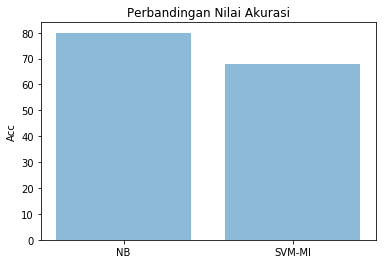

In [13]:
import matplotlib.pyplot as plt

objects = ['NB','SVM-MI']
y_pos = np.arange(len(objects))

a = plt.bar(y_pos, acc_non_stem ,align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Perbandingan Nilai Akurasi')
 
plt.show()

## Plot dengan Stemming

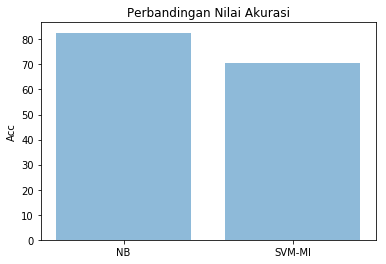

In [14]:
import matplotlib.pyplot as plt

objects = ['NB','SVM-MI']
y_pos = np.arange(len(objects))
 
plt.bar(y_pos, acc_stem ,align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Perbandingan Nilai Akurasi')
 
plt.show()

## Gabungan Plot dengan dan tanpa Stemming

In [15]:
akurasi = []
for i in range(len(acc_stem)):
    akurasi.append(acc_non_stem[i])
    akurasi.append(acc_stem[i])

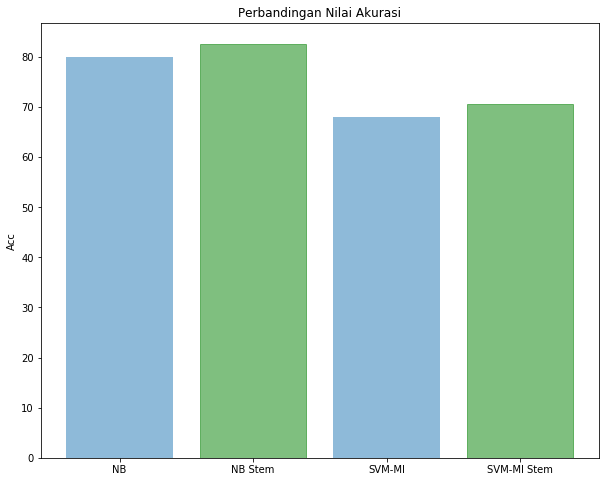

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
objects = ['NB', 'NB Stem','SVM-MI', 'SVM-MI Stem']
y_pos = np.arange(len(objects))
 
bar = plt.bar(y_pos, akurasi , alpha=0.5)
bar[1].set_color('g')
bar[3].set_color('g')

plt.xticks(y_pos, objects)
plt.ylabel('Acc')
plt.title('Perbandingan Nilai Akurasi')
 
plt.show()

### Jumlah Data dengan kelas Positif (1) dan Negatif (0)

In [17]:
satu, nol = 0, 0
for i in y_test:
    if i == '1':
        satu+=1
    else:
        nol+=1

In [18]:
satu

32

In [19]:
nol

43

### Kalimat yang salah diklasifikasi menggunakan Multinomial Naive Bayes (dengan Stemming) 

In [20]:
for i in (salah_nb_stem):
    print(i,"\n")

['sebenernya kesini karena tidak sengaja lewat dan kebetulan lagi haus juga  cobain minuman vanilla milkshake rasanya sih manis vanilla aja  trus juga takeaway makanan nya caesar salad dan sandwich menurutku untuk salad nya isiannya dikit  sayuran nya pilihan cuma ada selada aja dressingnya biasa aja  kalau buat sandwich nya juga kurang ada rasa alias hambar  gak bakal balik lagi sih kesini mending cobain ditempat lain saja', '1', '0'] 

["saung or warung nasi pengkolan 1 located in setaibudi street which is very crowded on weekend with local tourist    the restaurant is like rest area if you are hungry due to the bad traffic jam from bandung city towards lembang  the restaurant is in slope of lembang  they also offer good view of crops land and the green  the place is very spacious and have many seating both for small or big group  unfortunately  the place isn't well maintained and looks dirty  the worst is the service  that you can't easily call the waiters for menu or for help  the 

### Kalimat yang salah diklasifikasi menggunakan SVM Linear (dengan Stemming) 

In [21]:
for i in (salah_svm_stem):
    print(i,"\n")

['sebenernya kesini karena tidak sengaja lewat dan kebetulan lagi haus juga  cobain minuman vanilla milkshake rasanya sih manis vanilla aja  trus juga takeaway makanan nya caesar salad dan sandwich menurutku untuk salad nya isiannya dikit  sayuran nya pilihan cuma ada selada aja dressingnya biasa aja  kalau buat sandwich nya juga kurang ada rasa alias hambar  gak bakal balik lagi sih kesini mending cobain ditempat lain saja', '1', '0'] 

["saung or warung nasi pengkolan 1 located in setaibudi street which is very crowded on weekend with local tourist    the restaurant is like rest area if you are hungry due to the bad traffic jam from bandung city towards lembang  the restaurant is in slope of lembang  they also offer good view of crops land and the green  the place is very spacious and have many seating both for small or big group  unfortunately  the place isn't well maintained and looks dirty  the worst is the service  that you can't easily call the waiters for menu or for help  the 

### Visualisasi Data Uji dengan TSNE

In [22]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/indraaristya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


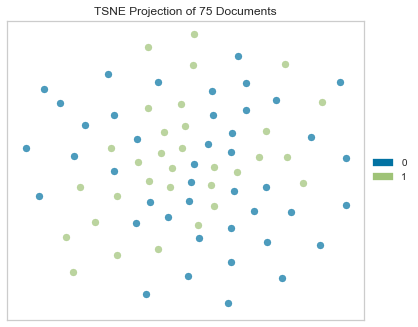

In [23]:
tsne = TSNEVisualizer()
tsne.fit(x_mi_test_stem, y_test)
tsne.poof()